In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置 Matplotlib 使用 SimHei 字体
rcParams['font.family'] = ['SimHei']  # 指定中文字体
rcParams['axes.unicode_minus'] = False  # 正常显示负号


In [2]:
# 加载训练和测试数据
train_df = pd.read_csv('../dataset/train_data.csv')
test_df = pd.read_csv('../dataset/test_data.csv')

# 删除不需要的列
columns_to_drop = ['instant', 'dteday']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

# 查看每列的缺失值数量
print("训练集缺失值:\n", train_df.isnull().sum())
print(train_df.info())

# 删除含有缺失值的行
train_df = train_df.dropna()
test_df = test_df.dropna()

训练集缺失值:
 season        3
yr            3
mnth          3
hr            3
holiday       3
weekday       3
workingday    3
weathersit    3
temp          3
atemp         3
hum           3
windspeed     3
casual        3
registered    3
cnt           3
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15219 entries, 0 to 15218
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      15216 non-null  float64
 1   yr          15216 non-null  float64
 2   mnth        15216 non-null  float64
 3   hr          15216 non-null  float64
 4   holiday     15216 non-null  float64
 5   weekday     15216 non-null  float64
 6   workingday  15216 non-null  float64
 7   weathersit  15216 non-null  float64
 8   temp        15216 non-null  float64
 9   atemp       15216 non-null  float64
 10  hum         15216 non-null  float64
 11  windspeed   15216 non-null  float64
 12  casual      15216 non-null  float64
 13  registere

In [3]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
categorical_features = ['yr', 'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
target = 'cnt'

# 特征归一化
scaler_features = MinMaxScaler()
train_df[numeric_features] = scaler_features.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler_features.transform(test_df[numeric_features])

features = numeric_features + categorical_features
# 最终检查
print("\n最终训练集信息:")
print(train_df.info())

print("\n最终测试集信息:")
print(test_df.info())


最终训练集信息:
<class 'pandas.core.frame.DataFrame'>
Index: 15216 entries, 0 to 15215
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      15216 non-null  float64
 1   yr          15216 non-null  float64
 2   mnth        15216 non-null  float64
 3   hr          15216 non-null  float64
 4   holiday     15216 non-null  float64
 5   weekday     15216 non-null  float64
 6   workingday  15216 non-null  float64
 7   weathersit  15216 non-null  float64
 8   temp        15216 non-null  float64
 9   atemp       15216 non-null  float64
 10  hum         15216 non-null  float64
 11  windspeed   15216 non-null  float64
 12  casual      15216 non-null  float64
 13  registered  15216 non-null  float64
 14  cnt         15216 non-null  float64
dtypes: float64(15)
memory usage: 1.9 MB
None

最终测试集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 15 columns):
 #   Column      Non-Null 

In [4]:
def create_sequences(df, input_steps, output_steps, features, target, sw=1):
    X = []
    y = []
    num = (len(df) - input_steps - output_steps)/sw + 1
    for i in range(int(num)):
        X_seq = df[features].iloc[i:i+input_steps].values
        y_seq = df[target].iloc[i+input_steps:i+input_steps+output_steps].values
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# 定义输入和输出的时间步长
input_steps = 96
output_steps_short = 96

# 创建短期预测的训练集
X_short, y_short = create_sequences(train_df, input_steps, output_steps_short, features, target)
print(f'短期预测 - 输入形状: {X_short.shape}, 输出形状: {y_short.shape}')

# 划分比例
split_ratio = 0.8

# 短期预测
split_index_short = int(X_short.shape[0] * split_ratio)
X_train_short = X_short[:split_index_short]
y_train_short = y_short[:split_index_short]
X_val_short = X_short[split_index_short:]
y_val_short = y_short[split_index_short:]

X_test_short, y_test_short = create_sequences(test_df, input_steps, output_steps_short, features, target)

print(f'短期预测 - 训练集: {X_train_short.shape}, 验证集: {X_val_short.shape}')
print(f'短期预测 - 测试集: {X_test_short.shape}')

短期预测 - 输入形状: (15025, 96, 14), 输出形状: (15025, 96)
短期预测 - 训练集: (12020, 96, 14), 验证集: (3005, 96, 14)
短期预测 - 测试集: (1969, 96, 14)


In [5]:
class BikeSharingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

# 短期预测数据加载器
train_dataset_short = BikeSharingDataset(X_train_short, y_train_short)
val_dataset_short = BikeSharingDataset(X_val_short, y_val_short)
train_loader_short = DataLoader(train_dataset_short, batch_size=batch_size, shuffle=True)
val_loader_short = DataLoader(val_dataset_short, batch_size=batch_size, shuffle=False)
test_dataset_short = BikeSharingDataset(X_test_short, y_test_short)
test_loader_short = DataLoader(test_dataset_short, batch_size=batch_size, shuffle=False)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_steps = output_steps
        
        # 堆叠多个LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接层
        self.fc1 = nn.Linear(hidden_size, 128)
        self.batch_norm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_steps)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)
        
        # 取最后一个时间步的输出
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # Dropout
        out = self.dropout(out)
        
        # 全连接层
        out = self.fc1(out)
        out = self.batch_norm(out)
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.fc3(out)
        
        return out


In [7]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device, max_grad_norm=1.0):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # 每 10 个 epoch 学习率衰减为原来的 0.1
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # 前向传播
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # 验证
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_running_loss += loss.item() * X_val.size(0)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
        
        # 每个 epoch 后更新学习率
        # scheduler.step()

    return train_losses, val_losses


In [96]:
# 设置训练参数
num_epochs = 400
learning_rate = 0.005
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_experiments = 5

# 获取输入特征数量
input_size = len(features)

# 短期预测模型参数
hidden_size_short = 64
num_layers_short = 3
output_steps_short = 96

def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

for exp in range(num_experiments):
    print(f"正在进行实验 {exp+1} ...")
    model_short = LSTMModel(input_size, hidden_size_short, num_layers_short, output_steps_short)
    model_short = model_short.to('cuda' if torch.cuda.is_available() else 'cpu')
    model_short.apply(init_weights)
    train_losses, val_losses = train_model(
        model_short, train_loader_short, val_loader_short, num_epochs, learning_rate, device
    )
    torch.save(model_short.state_dict(), f'./short_model/model_short_{exp+1}.pth')

# 保存loss
train_losses_df = pd.DataFrame(train_losses)
val_losses_df = pd.DataFrame(val_losses)
train_losses_df.to_csv('./short_model/train_losses.csv', index=False)
val_losses_df.to_csv('./short_model/val_losses.csv', index=False)


正在进行实验 1 ...
Epoch [1/400], Train Loss: 45082.3295, Val Loss: 97799.2666
Epoch [2/400], Train Loss: 28161.0175, Val Loss: 55243.5681
Epoch [3/400], Train Loss: 14918.0983, Val Loss: 36248.3317
Epoch [4/400], Train Loss: 11156.0376, Val Loss: 31143.9048
Epoch [5/400], Train Loss: 9817.3603, Val Loss: 26768.0179
Epoch [6/400], Train Loss: 9437.6307, Val Loss: 23627.9154
Epoch [7/400], Train Loss: 9041.4492, Val Loss: 20975.3075
Epoch [8/400], Train Loss: 8640.9992, Val Loss: 29153.4086
Epoch [9/400], Train Loss: 8481.5523, Val Loss: 25793.7050
Epoch [10/400], Train Loss: 8316.5358, Val Loss: 24145.8898
Epoch [11/400], Train Loss: 8184.0178, Val Loss: 25007.4790
Epoch [12/400], Train Loss: 8089.6168, Val Loss: 23112.9655
Epoch [13/400], Train Loss: 7975.7250, Val Loss: 22878.2734
Epoch [14/400], Train Loss: 7801.1468, Val Loss: 24188.7446
Epoch [15/400], Train Loss: 7601.3277, Val Loss: 26633.6289
Epoch [16/400], Train Loss: 7310.0870, Val Loss: 20493.4726
Epoch [17/400], Train Loss: 7049

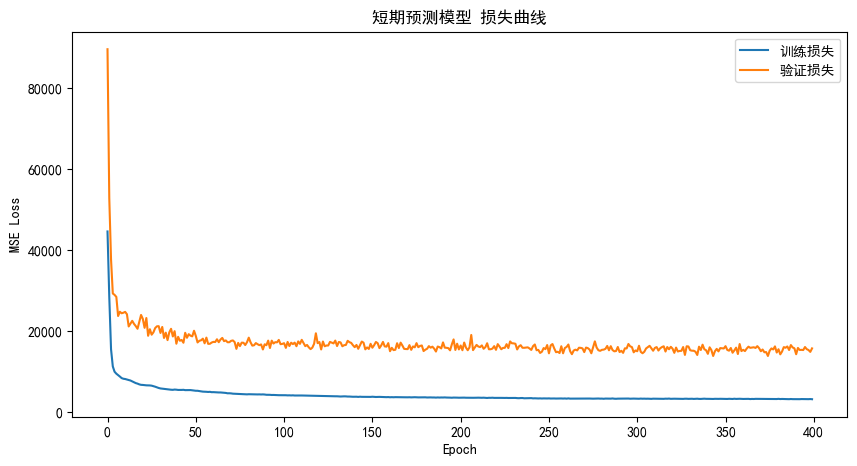

In [8]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='训练损失')
    plt.plot(val_losses, label='验证损失')
    plt.title(f'{title} 损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

# 读取损失
train_losses = pd.read_csv('./short_model/train_losses.csv').values
val_losses = pd.read_csv('./short_model/val_losses.csv').values
# 绘制短期预测模型的损失曲线
plot_losses(train_losses, val_losses, '短期预测模型')

短期预测模型 - 平均 MSE: 22436.8875, 平均 MAE: 101.2068
短期预测模型 - MSE 标准差: 2481.3817, MAE 标准差: 6.7316


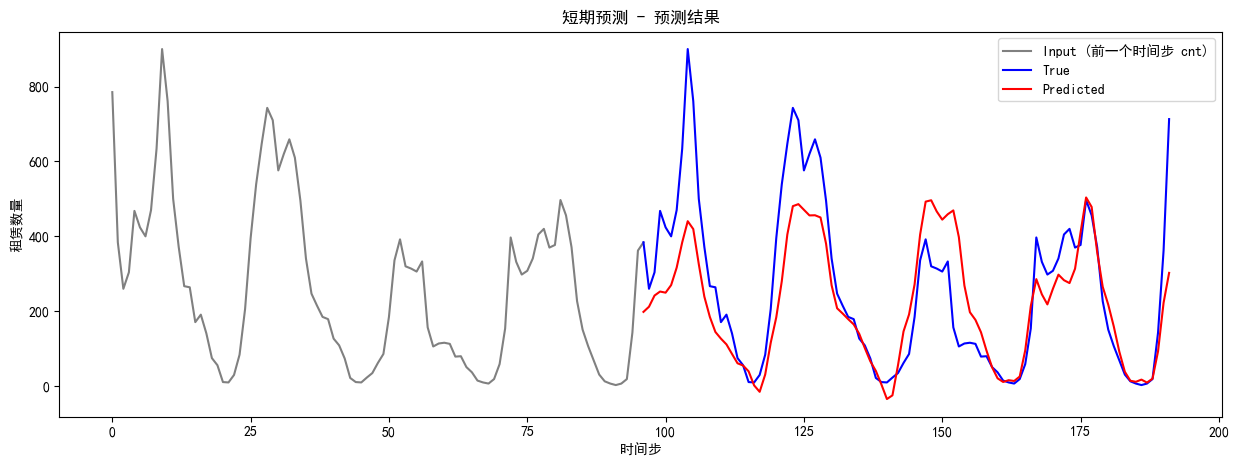

In [10]:
def evaluate_model(model, val_loader, device):
    model.eval()
    predictions = []
    actuals = []
    inputs = []  # 用于存储输入序列
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_val.cpu().numpy())
            inputs.append(X_val.cpu().numpy())  # 收集输入序列
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    inputs = np.concatenate(inputs, axis=0)  # 合并所有输入序列
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    
    return mse, mae, inputs, actuals, predictions

# 设置训练参数
num_epochs = 400
learning_rate = 0.005
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_experiments = 5

# 获取输入特征数量
input_size = len(features)

# 短期预测模型参数
hidden_size_short = 64
num_layers_short = 3
output_steps_short = 96
mse_list = []
mae_list = []

for exp in range(num_experiments):
    model_short = LSTMModel(input_size, hidden_size_short, num_layers_short, output_steps_short)
    model_short = model_short.to('cuda' if torch.cuda.is_available() else 'cpu')
    model_short.load_state_dict(torch.load(f'./short_model/model_short_{exp+1}.pth', weights_only=False))
    mse, mae, inputs_short, actuals_short, predictions_short = evaluate_model(model_short, test_loader_short, device)
    mse_list.append(mse)
    mae_list.append(mae)

std_mse = np.std(mse_list)
std_mae = np.std(mae_list)
print(f'短期预测模型 - 平均 MSE: {np.mean(mse_list):.4f}, 平均 MAE: {np.mean(mae_list):.4f}')
print(f'短期预测模型 - MSE 标准差: {std_mse:.4f}, MAE 标准差: {std_mae:.4f}')

# 最佳模型
best_model_idx = np.argmin(mse_list)
model_short = LSTMModel(input_size, hidden_size_short, num_layers_short, output_steps_short)
model_short = model_short.to('cuda' if torch.cuda.is_available() else 'cpu')
model_short.load_state_dict(torch.load(f'./short_model/model_short_{best_model_idx+1}.pth', weights_only=False))
mse, mae, inputs_short, actuals_short, predictions_short = evaluate_model(model_short, test_loader_short, device)

def plot_predictions_with_input(inputs, actual, predicted, sample_idx, title):
    plt.figure(figsize=(15, 5))
    
    input_steps = inputs.shape[1]
    output_steps = actual.shape[1]
    total_steps = input_steps + output_steps
    
    # 提取特定样本的输入、实际和预测数据
    actual_seq = actual[sample_idx]
    predicted_seq = predicted[sample_idx]
    
    last_input_cnt = list(actual[sample_idx - 1][-input_steps:])
    last_input_cnt.append(actual[sample_idx][0])
    
    # 绘制输入序列
    plt.plot(range(input_steps+1), last_input_cnt, label='Input (前一个时间步 cnt)', color='gray')
    
    # 绘制实际值
    plt.plot(range(input_steps, total_steps), actual_seq, label='True', color='blue')
    
    # 绘制预测值
    plt.plot(range(input_steps, total_steps), predicted_seq, label='Predicted', color='red')
    
    plt.title(f'{title} - 预测结果')
    plt.xlabel('时间步')
    plt.ylabel('租赁数量')
    plt.legend()
    plt.show()


plot_predictions_with_input(inputs_short, actuals_short, predictions_short, 1, '短期预测')
